In [1]:
import os
from os.path import join as pjoin
from scipy.io import wavfile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
tf.config.list_physical_devices('GPU')

original_data_dir = pjoin(os.getcwd(),"..\\AudioFiles","wavs")
compressed_data_dir = pjoin(os.getcwd(),"..\\AudioFiles","medio")
original_fname = pjoin(original_data_dir, '55_tdcast.wav')
compressed_fname = pjoin(compressed_data_dir, '55_tdcast.wav')

In [2]:
samplerate, original_data = wavfile.read(original_fname)
print(f"number of channels = {original_data.shape[1]}")

length = original_data.shape[0] / samplerate
print(f"length = {length}s")

samplerate, compressed_data = wavfile.read(compressed_fname)

number of channels = 2
length = 1379.4220408163264s


<ipython-input-2-9493e236311b>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, compressed_data = wavfile.read(compressed_fname)


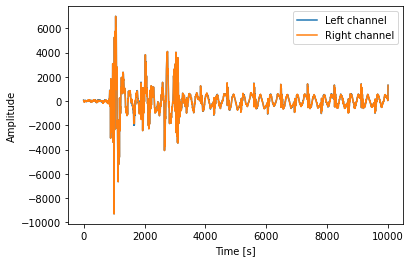

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# time = np.linspace(0., 10000, data.shape[0])
plt.plot(original_data[10000:20000, 0], label="Left channel")
plt.plot(original_data[10000:20000, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [4]:
def getSamplesFromFile(file, samplesize):
    n_chunks = len(file)//samplesize
    return file[:n_chunks*samplesize].reshape(-1,samplesize,1)

In [5]:
a = np.array([1,2,3,4,5,6,7,2])
getSamplesFromFile(a, 5)

array([[[1],
        [2],
        [3],
        [4],
        [5]]])

In [15]:
max_data = np.max(original_data[:, 0].astype(np.float32))

In [6]:
samplesize = 1000
data = original_data[:, 0].astype(np.float32)
data = data/np.max(data)
y = getSamplesFromFile(original_data, samplesize)
x = getSamplesFromFile(compressed_data, samplesize)

In [7]:
val_start = int(len(x)*.9)
X_train,X_valid = x[:val_start-1],x[val_start-1:-1]
Y_train,Y_valid = y[1:val_start],y[val_start:]

snipsize = 50
Y_train, Y_valid = Y_train[:,:snipsize], Y_valid[:,:snipsize]

In [8]:
#

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    
    keras.layers.LSTM(snipsize, return_sequences=True,input_shape=[None, 1])
])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
Total params: 10,400
Trainable params: 10,400
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss="mse", optimizer="adam")

In [10]:
print(X_train.shape, X_valid.shape)
print(Y_train.shape, Y_valid.shape)

(109496, 1000, 1) (12167, 1000, 1)
(109496, 50, 1) (12167, 50, 1)


In [11]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=1024,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
107/107 [==============================] - 18s 172ms/step - loss: 20595182.0000 - val_loss: 22317804.0000
Epoch 2/20
107/107 [==============================] - 18s 165ms/step - loss: 20594356.0000 - val_loss: 22317384.0000
Epoch 3/20
107/107 [==============================] - 18s 166ms/step - loss: 20594120.0000 - val_loss: 22317196.0000
Epoch 4/20
107/107 [==============================] - 18s 170ms/step - loss: 20594070.0000 - val_loss: 22317198.0000
Epoch 5/20
107/107 [==============================] - 18s 169ms/step - loss: 20594066.0000 - val_loss: 22317220.0000
Epoch 6/20
107/107 [==============================] - 18s 168ms/step - loss: 20594090.0000 - val_loss: 22317228.0000
Epoch 7/20
107/107 [==============================] - 18s 171ms/step - loss: 20593980.0000 - val_loss: 22317114.0000
Epoch 8/20
107/107 [==============================] - 19s 177ms/step - loss: 20593964.0000 - val_loss: 22317090.0000
Epoch 9/20
107/107 [==============================] - 18s 167ms/

In [13]:
audio_buffer = list(np.array(X_train[0].reshape(-1)))
for i in tqdm(range(int(samplerate*10/snipsize))):
    snip = model.predict(x[i*snipsize:1000+i*snipsize]).reshape(-1)
    audio_buffer += snip.data

  8%|██████▌                                                                      | 746/8820 [06:20<1:08:40,  1.96it/s]


KeyboardInterrupt: 

In [14]:
len(audio_buffer)

37301000

In [50]:
np.concatenate((audio_buffer, Y_train[0].reshape(-1))).shape

(1020,)

In [16]:
import simpleaudio as sa

audio = np.array(audio_buffer)*max_data.astype(np.int16)#data[10000:200000, 0].astype(np.int16)

# Start playback
play_obj = sa.play_buffer(audio, 1, 2, samplerate)

# Wait for playback to finish before exiting
play_obj.wait_done()

KeyboardInterrupt: 